In [120]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import ZScaleInterval

import matplotlib.pyplot as plt
import matplotlib.cm as cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download and Visualize HSC Images

* You will use the HSC Public Data Release data (`PDR`) and you need to have an account on the PDF website.
* You will use a Python tool called `unagi` to download HSC images. 
    - You can find the code here on `Github`: https://github.com/dr-guangtou/unagi
    - On you computer, you can type `git clone git@github.com:dr-guangtou/unagi.git unagi` to download it to your computer. And use `python3 setup.py install` to install it.
    - In case you are not familar with `git` or you don't have it on your computer, you can also download a `zip` file from the `Github` repo. After you decompress it, you can install it too.
* Before you can use `unagi`, you need to let the system know about your username and password.
    - You can use something called environment variables for your system. For example, if you use `bash` in your command-line, you can edit the `.bashrc` or `.bash_profile` file under your home directory to add two variables:

```
export SSP_PDR_USR="your_user_name_here"
export SSP_PDR_PWD="your_password_here"
```
    - After you save the file, you can do `source ~/.bashrc` to update it.

In [ ]:
# You can also do this in the Notebook

os.environ["SSP_PDR_USR"] = "your_user_name"
os.environ["SSP_PDR_PDR"] = "your_password"

* After installing `unagi` and setup your user information, you should be able to import `unagi` and config it to download data for you

In [2]:
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout
from unagi.task import hsc_tricolor

# We are using HSC PDR2-Wide data
pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


* Please check out [this demo](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_cutout.ipynb) to learn more details about how to use `unagi` to download cutout HSC images
* And you also need to install `astropy` library. This can be done by `pip install --upgrade astropy`

In [3]:
# Coordinate of the galaxy 
coord = SkyCoord(177.34765, -1.08402, frame='icrs', unit='deg')

# Prefix: You can name your galaxy to make it easy to remember
prefix = 'edgeon_test_1'

# Angular size of the cutout image
s_ang = 60.0 * u.arcsec

# Filters; normally g+r+i 3-band is good enough
filters = 'gri'

# Output dir: place to keep the output data. You should create your own folder.
output_dir = '.'

* Now we download the cutout images in `gri` bands at the same time

In [4]:
cutout_gri = hsc_cutout(coord, cutout_size=s_ang, filters='gri', archive=pdr2, prefix=prefix,
                        use_saved=True, output_dir=output_dir, verbose=True, save_output=True)

# cutout_gri contains three sets of data for g, r, & i band
# cutout_gri[0] is the g-band; [1] is r-band, etc
print(len(cutout_gri))

# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i']
# Read in saved FITS file: ./edgeon_test_1_g.fits
# Read in saved FITS file: ./edgeon_test_1_r.fits
# Read in saved FITS file: ./edgeon_test_1_i.fits
3


In [5]:
# Let's separate the data into each filter to make it clear
g_data = cutout_gri[0]
r_data = cutout_gri[1]
i_data = cutout_gri[2]

* The output data are not simple `numpy` array, but it is a `HDUList` structure, which contain multiple data.
    - It is basically a list of `FITS` data structure. If you want to know more about this data structure, read this [`astropy` manual](https://docs.astropy.org/en/stable/io/fits/)
    - Data in each band contains 4 elements. Each element is a `FITS` `HDU`, which is a data structure that contains something called `header` and the actualy data. "header" is just a list of metadata.
    - The HSC data structure in each band is:
        1. Empty slot. Only has header information of the image.
        2. Science image --> This is the only one we are going to use.
        3. Variance image: contains per-pixel error information.
        4. Mask image: tell per-pixel mask information. You can use [this demo](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_mask.ipynb) to learn more about the HSC mask plane.

In [6]:
# Let's print out the header for g-band

g_data[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT DAS Cutout version 180619                                               
HIERARCH variance_scale = 1.12633671287528                                      
BGMEAN  =   0.0064039669045626                                                  
BGVAR   = 0.000126692979012756                                                  
AR_HDU  =                    5 / HDU (1-indexed) containing the archive used to 
HIERARCH COADD_INPUTS_ID = 1 / archive ID for coadd inputs catalogs             
HIERARCH AP_CORR_MAP_ID = 20

In [7]:
# Now let's separate the three-band science images
g_image = g_data[1].data
r_image = r_data[1].data
i_image = i_data[1].data

# Now we store the image into 2-D numpy array

* We can now check out these image using the `plotting.display_single` or `plotting.display_all` function
* As I mentioned earlier, astro-image has a very large dynamic range and very weird pixel-value distribution
    - For example, the i-band image has a range of:

In [8]:
print(np.nanmin(i_image), np.nanmax(i_image))

-3.9209878 220.67715


* This does not look very bad, but if you look at the pixel distribution...
    - You can see that most pixels have value close to zero (note the log Y-axis)...
    - So the image has to be stretched to enhance the structure you want to see.
    - There are multiple ways to do this. If you want to know more, you can read about it [here](https://docs.astropy.org/en/stable/visualization/normalization.html)
    - Also notice that there are a lot of negative pixels. Remember that the image is background subtracted and has intrinsic noise.

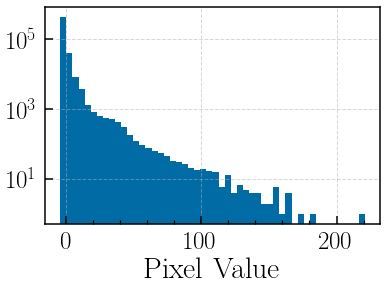

In [59]:
_ = plt.hist(i_image.flatten(), bins=50, log=True)
_ = plt.xlabel(r'$\rm Pixel\ Value$', fontsize=30)

In [10]:
# Fraction of pixels that have <0 pixel values
(i_image < 0).sum() / i_image.sum()

0.1952149025025537

* Let's try to show the structure of the galaxy: bulge, disk, dust lane first.
    - This require a low contrast, meaning we don't want to enhance the low value pixels a lot.
    - And we normaly use the `arcsinh` function to stretch the image, which is much better than `linear` and less agressive than `log10`.

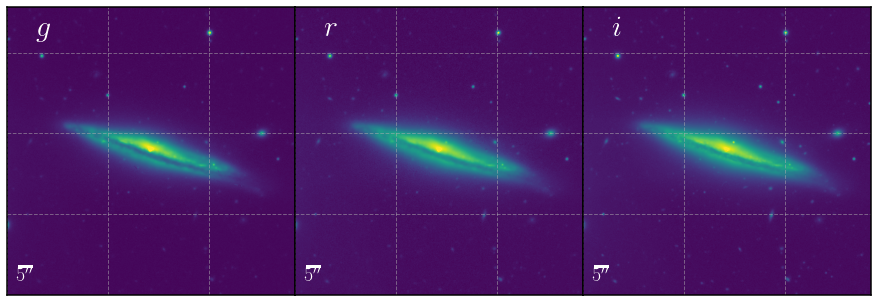

In [11]:
label_list = [r"${:s}$".format(label) for label in ['g', 'r', 'i']]
img_list = [g_data[1], r_data[1], i_data[1]]

# First let's try to see some structure details.
# We use `arcsinh` stretch function to 
_ = plotting.display_all(
    img_list, hdu_list=True, img_size=4, label_list=label_list, fontsize=30, fontcolor='w', 
    stretch='arcsinh', hdu_start=0, contrast=0.01)

* If we really enhance the low surface brightness feature, we can increase the contrast and using different scaling of the image
    - For example we can set the upper limit of pixel value at 75% of the maximum value using the `percentile` scaling.
* Now you can see that the galaxy becomes "puffier" because we can see the low surface brightness feature better.
    - Also we can see there is a lot of light from the left side, that's another galaxy.
    - Also on the i-band image, we can see the bottom-right corner is really dark. That's because the image become negative due to over-subtracted background.

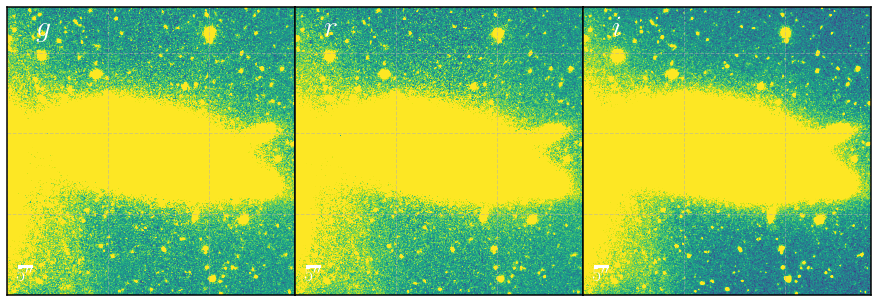

In [12]:
_ = plotting.display_all(
    img_list, hdu_list=True, img_size=4, label_list=label_list, fontsize=30, fontcolor='w', 
    stretch='arcsinh', hdu_start=0, contrast=0.2, scale='percentile', upper_percentile=60.0)

* We can also generate three-color pseudo-color picture of these, and we do want to use low constrast mode for it.
    - You can learn about the 3-color image more [here](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_color_image.ipynb)
    - Here there is also a parameter that controls the "stretch" of the image: `rgb_stretch`.
    - But due to different definition, here lower `rgb_stretch` value actualy means higher contrast.
    - Using `rgb_stretch=0.2` can help us see the disk and the "puffy" part nicely.

# Read in saved FITS file: True
# Read in saved FITS file: True
# Read in saved FITS file: True


[]

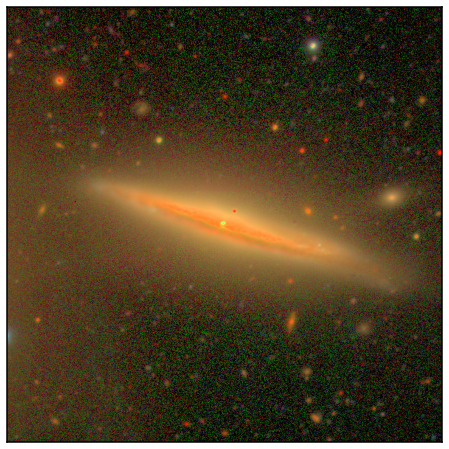

In [117]:
# Use angular size and don't save the data
cutout_rgb, cutout_wcs = hsc_tricolor(
    coord, cutout_size=s_ang, filters=filters, verbose=True, rgb_stretch=0.2, rgb_q=15,
    save_rgb=False, save_img=False, use_saved=True, archive=pdr2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cutout_rgb, origin='lower')
ax.set_xticks([])
ax.set_yticks([])

* This is already pretty good, but we can do better!
* What if we want to see the diffuse stuff clearly without loosing details in the bright part? 
    - We can do that through a slightly more complicated trick

In [152]:
# Now we convolve the image with a 2-D Gaussian kernel. 
# This will smooth the image a little so it help suppress the noise a little in the low surface brightness region
kernel = Gaussian2DKernel(x_stddev=1.0)
g_conv = convolve(g_image, kernel)

# We definie a pixel value boundary that separate the low surface brightness and high surface brightness part.
# Try to use 80%
upper_val = np.percentile(g_image, 85.0)
upper_mask = g_image >= upper_val

# Now we "mask" all the pixels that belong to the "bright" part as "bad" pixel
# np.nan: NaN, Not-a-Number, is a graceful way to say "this is bad"
g_conv[upper_mask] = np.nan

# Now let's scale the image using the arcsinh function
g_scale = np.arcsinh(g_conv)

# And decide the appropriate lower and upper limit of pixel values to enhance structure.
vmin, vmax = ZScaleInterval(contrast=0.8).get_limits(g_scale)

-0.025848396 0.07758181228221567


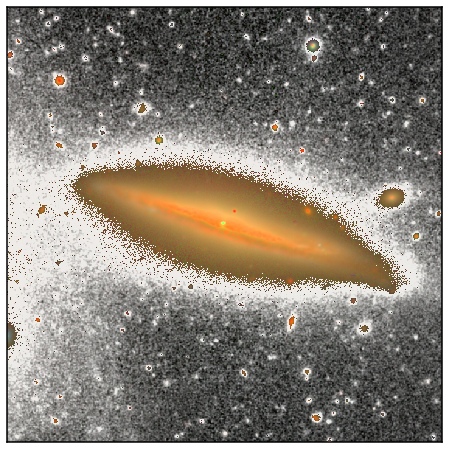

In [154]:
fig, ax = plt.subplots(figsize=(8, 8))

# Show the 3-color image to highlight the detailed structure of the main body of the galaxy
ax.imshow(cutout_rgb, origin='low', alpha=1.0)

# Now let's define our own color-map
my_cmap = cm.gray
# And we make sure it will set all bad pixels completely transparent
my_cmap.set_bad('w', alpha=0.0)

# Now let's show the low surface brightness part.
ax.imshow(g_scale, cmap=my_cmap, interpolation='none', origin='low', 
          vmin=vmin, vmax=vmax, clim=[np.min(g_image), upper_val], alpha=0.9)

_ = ax.set_xticks([])
_ = ax.set_yticks([])